In [33]:
import random
import copy
import time
import matplotlib.pyplot as plt
from shapely.geometry import LineString

random.seed(100)

In [34]:
def read_data(filename: str) -> (list, list):
    with open('./data/' + filename) as f:
        size = list(map(int, f.readline().split(';')))
        coordinates = [list(map(int, i.split(';'))) for i in f.readlines()]
        return size, coordinates


def line_intersect(x1, y1, x2, y2, x3, y3, x4, y4) -> bool:
    return LineString([(x1, y1), (x2, y2)]).intersects(LineString([(x3, y3), (x4, y4)]))

In [35]:
SAVE_IMAGES = True
TURN_ON_RANDOM_ALGORITHM = True
TURN_ON_GENETIC_ALGORITHM = True
SELECTION_TYPE_PARENT1 = 0
SELECTION_TYPE_PARENT2 = 0
POPULATION_SIZE = 20
CROSSOVER_CHANCE = 0.75
MUTATION_CHANCE = 0.14
MUTATION_SEGMENT_DISTANCE = 1
MUTATION_SEGMENT_PIVOT = 2
MUTATION_VARIANT_B_CHANCE = 0.4
SELECTION_SIZE = 5
EPOCHES = 1500
LINE_DIS = 40
MAX_SEGMENTS = 4
MAX_SEGMENT_DIS = 3
COST_FUNCTION_WEIGHTS = [25, 0.1, 0.7, 12, 15]

# Dynamic variables
(field_width, field_height), coordinates = read_data('zad3.txt')

In [36]:
class Individual:
    def __init__(self):
        self.paths = []


    def __str__(self):
        return '\n'.join(str(i) for i in self.paths)


    def calculate_fitness_score(self):
        summary_distance = 0
        summary_segments = 0
        crossouts = 0
        summary_distance_outside = 0
        summary_segments_outside = 0
        
        lines = []
        for path in self.paths:
            summary_segments += len(path.segments)

            x, y = path.xs, path.ys
            for seg in path.segments:
                summary_distance += seg.dis 

                xe, ye = x, y
                if seg.dir == 'U': ye -= seg.dis
                if seg.dir == 'D': ye += seg.dis
                if seg.dir == 'L': xe -= seg.dis
                if seg.dir == 'R': xe += seg.dis
                lines.append([x, y, xe, ye, path])

                for i in range(seg.dis):
                    if x <= 0 or y <= 0 or x > field_width or y > field_height: summary_distance_outside += 1
                    if seg.dir == 'U': y -= 1
                    if seg.dir == 'D': y += 1
                    if seg.dir == 'L': x -= 1
                    if seg.dir == 'R': x += 1
                
                if x <= 0 or x > field_width or y <= 0 or y >= field_height: summary_segments_outside += 1
                else:
                    if seg.dir == 'D' and y - seg.dis <= 0: summary_segments_outside += 1
                    if seg.dir == 'U' and y + seg.dis > field_height: summary_segments_outside += 1
                    if seg.dir == 'R' and x - seg.dis <= 0: summary_segments_outside += 1
                    if seg.dir == 'L' and x + seg.dis > field_width: summary_segments_outside += 1

        for i in range(len(lines) - 1):
            for j in range(i + 1, len(lines)):
                if line_intersect(*lines[i][:-1], *lines[j][:-1]):
                    crossouts += 1

        summary_distance_outside += 1 if summary_distance_outside != 0 else 0
        self.fitness_score = sum([a * b for a, b in zip([crossouts, summary_distance, summary_segments, summary_segments_outside, summary_distance_outside], COST_FUNCTION_WEIGHTS)])
        return self.fitness_score

class Path:
    def __init__(self, xs=0, ys=0, xe=0, ye=0):
        self.xs = xs
        self.ys = ys
        self.xe = xe
        self.ye = ye
        self.segments = []
        self.color = '#%06X' % random.randint(0, 256 ** 3 - 1)


    def __str__(self):
        return self.color + '\n(%s, %s); (%s, %s);\n' % (self.xs, self.ys, self.xe, self.ye) + '\t'.join(str(i) for i in self.segments)

class Segment:
    def __init__(self, dir='', dis=0):
        self.dir = dir
        self.dis = dis


    def __str__(self):
        return '[%s, %s]' % (self.dir, self.dis)

In [37]:
def against_direction(key: str) -> str:
    return { 'R': 'L', 'L': 'R', 'U': 'D', 'D': 'U' }.get(key)


def gen_random_segments(path):
    if path.xs == path.xe and path.ys == path.ye: return []

    x, y = path.xs, path.ys
    prev_direction = None
    segments = []

    for i in range(random.randint(2, MAX_SEGMENTS)):
        if x == path.xe and y == path.ye: return segments

        directions = ['U', 'D', 'L', 'R']
        # Remove previous and same direction
        if prev_direction: 
            directions.remove(prev_direction)
            directions.remove(against_direction(prev_direction))
        
        direction = random.choice(directions)
        distance = random.randint(1, MAX_SEGMENT_DIS)

        segment = Segment(direction, distance)
        segments.append(segment)

        if direction == 'U': y -= distance
        if direction == 'D': y += distance
        if direction == 'R': x += distance
        if direction == 'L': x -= distance

        prev_direction = direction

    # Here we need to find closest way to the end point
    # Also we have previous direction, so we cant move there
    # In this place x, y can not be equal the end point
    directions = ['U', 'D', 'L', 'R']
    directions.remove(prev_direction)
    directions.remove(against_direction(prev_direction))

    direction = random.choice(directions)
    distance = random.randint(1, MAX_SEGMENT_DIS)
    additional_direction = False

    if prev_direction in 'UD' and x == path.xe:
        segments.append(Segment(direction, distance))
        x += distance * (1 if direction == 'R' else -1)
        additional_direction = True
    elif prev_direction in 'LR' and y == path.ye:
        segments.append(Segment(direction, distance))
        y += distance * (1 if direction == 'D' else -1)
        additional_direction = True

    # Here we know we need to connect with two segments
    # thats why lets first find direction to 
    h_distance = path.xe - x
    v_distance = path.ye - y
    с1 = Segment('R' if h_distance > 0 else 'L', abs(h_distance))
    с2 = Segment('D' if v_distance > 0 else 'U', abs(v_distance))

    if not additional_direction: direction = prev_direction
    if direction in 'UD': 
        segments.append(с1)
        segments.append(с2)
    elif direction in 'LR': 
        segments.append(с2)
        segments.append(с1)

    return segments


def initial_population() -> list:
    population = []
    for _ in range(POPULATION_SIZE):
        individual = Individual()
        for [x, y, xe, ye] in coordinates:
            path = Path(x, y, xe, ye)
            path.segments = gen_random_segments(path)
            individual.paths.append(path)
        population.append(individual)
    return population


def fitness_proportionate_selection(array: list, k=1) -> Individual:
    return min(random.choices(array, [1 / ind.fitness_score for ind in array], k=k), key=lambda x: x.fitness_score)


def tournament_selection(array: list, k=1) -> Individual:
    return min(random.sample(array, k=k), key=lambda ind: ind.fitness_score)


def single_point_crossover(parent1: Individual, parent2: Individual) -> Individual:
    if random.random() > CROSSOVER_CHANCE:  
        return copy.deepcopy(parent1 if random.random() > 0.5 else parent2)

    pivot = random.randint(1, len(parent1.paths))
    child = Individual()
    
    child.paths = copy.deepcopy(parent1.paths[:pivot]) + copy.deepcopy(parent1.paths[pivot:])
    return child

  
def mutate(ind: Individual) -> None:
    if random.random() > MUTATION_CHANCE: return

    for path in ind.paths: 
        segment = random.choice(path.segments)
        idx = path.segments.index(segment)

        # Path B
        if random.random() > 1 - MUTATION_VARIANT_B_CHANCE:
            if segment.dis > MUTATION_SEGMENT_PIVOT:
                pivot = random.randint(1, segment.dis)
                segment.dis -= pivot
                path.segments.insert(idx + 1, Segment(segment.dir, pivot))
                idx += 1
                segment = path.segments[idx]

        # Path A
        if segment.dir in 'UD':
            _dir = 'L' if random.random() >= 0.5 else 'R'
            _again_dir = 'R' if _dir == 'L' else 'L'
            _dirs = 'UD'
        else:
            _dir = 'D' if random.random() >= 0.5 else 'U'
            _again_dir = 'U' if _dir == 'D' else 'D'
            _dirs = 'LR'

        if idx > 0 and path.segments[idx - 1].dir not in _dirs:
            path.segments[idx - 1].dis += MUTATION_SEGMENT_DISTANCE * (-1 if path.segments[idx - 1].dir == _again_dir else 1)
            if path.segments[idx - 1].dis == 0:
                path.segments.pop(idx - 1)
                idx -= 1
        else:
            path.segments.insert(idx, Segment(_dir, MUTATION_SEGMENT_DISTANCE))
            idx += 1

        if idx < len(path.segments) - 1 and path.segments[idx + 1].dir not in _dirs:
            path.segments[idx + 1].dis += MUTATION_SEGMENT_DISTANCE * (-1 if path.segments[idx + 1].dir == _dir else 1)
            if path.segments[idx + 1].dis == 0: 
                path.segments.pop(idx + 1)
        else: path.segments.insert(idx + 1, Segment(_again_dir, MUTATION_SEGMENT_DISTANCE))


        i = 0
        while True:
            if i >= len(path.segments): break

            if path.segments[i].dis == 0:
                path.segments.pop(i)
                continue

            if i > 0 and path.segments[i - 1].dir == path.segments[i].dir:
                path.segments[i - 1].dis += path.segments[i].dis
                path.segments.pop(i)
                continue

            if i > 0 and path.segments[i].dir == against_direction(path.segments[i - 1].dir):
                if path.segments[i - 1].dis < path.segments[i].dis:
                    path.segments[i - 1].dir = path.segments[i].dir
                    path.segments[i - 1].dis = path.segments[i].dis - path.segments[i - 1].dis
                elif path.segments[i - 1].dis > path.segments[i].dis:
                    path.segments[i - 1].dis -= path.segments[i].dis
                else:
                    path.segments.pop(i)
                    i -= 1
                path.segments.pop(i)
                i -=1 

            i += 1

Epoch:  0
Epoch:  150
Epoch:  300
Epoch:  450
Epoch:  600
Epoch:  750
Epoch:  900
Epoch:  1050
Epoch:  1200
Epoch:  1350


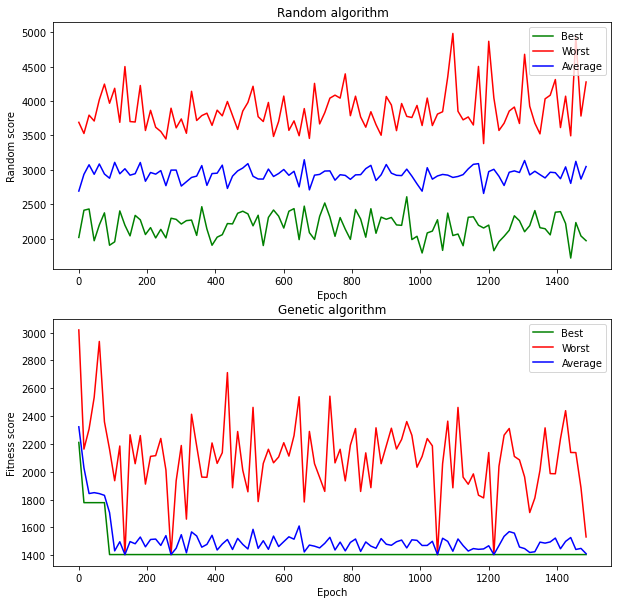

In [38]:
random_algorithm_dict = {
    'best': [],
    'worst': [],
    'avg': []
}

genetic_algorithm_dict = {
    'best': [],
    'worst': [],
    'avg': []
}

x_axis = 100

g_population = initial_population()

for ind in g_population:
    ind.calculate_fitness_score()

for j in range(EPOCHES):
    if TURN_ON_RANDOM_ALGORITHM:
        r_population = initial_population()
        for ind in r_population:
            ind.calculate_fitness_score()

    if TURN_ON_GENETIC_ALGORITHM:
        new_population = []

        for i in range(len(g_population)):
            a = tournament_selection(g_population, k=SELECTION_SIZE) if SELECTION_TYPE_PARENT1 == 1 else fitness_proportionate_selection(g_population, k=SELECTION_SIZE)
            b = tournament_selection(g_population, k=SELECTION_SIZE) if SELECTION_TYPE_PARENT1 == 1 else fitness_proportionate_selection(g_population, k=SELECTION_SIZE)
            
            child = single_point_crossover(a, b)
            mutate(child)

            child.calculate_fitness_score()
            new_population.append(child)

        g_population = list(new_population)
        new_population = []

    if j % (EPOCHES // x_axis) == 0:
        if TURN_ON_RANDOM_ALGORITHM:
            random_algorithm_dict['avg'].append(sum(x.fitness_score for x in r_population) / POPULATION_SIZE)
            random_algorithm_dict['best'].append(min(x.fitness_score for x in r_population))
            random_algorithm_dict['worst'].append(max(x.fitness_score for x in r_population))

        if TURN_ON_GENETIC_ALGORITHM:
            genetic_algorithm_dict['avg'].append(sum(x.fitness_score for x in g_population) / POPULATION_SIZE)
            genetic_algorithm_dict['best'].append(min(x.fitness_score for x in g_population))
            genetic_algorithm_dict['worst'].append(max(x.fitness_score for x in g_population))

    if j % (EPOCHES // 10) == 0: print('Epoch: ', j)


fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

x_axis = list(x * EPOCHES // x_axis for x in range(x_axis))
if TURN_ON_RANDOM_ALGORITHM:
    ax1.set_title('Random algorithm')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Random score')
    ax1.plot(x_axis, random_algorithm_dict['best'], color='green', label='Best')
    ax1.plot(x_axis, random_algorithm_dict['worst'], color='red', label='Worst')
    ax1.plot(x_axis, random_algorithm_dict['avg'], color='blue', label='Average')
    ax1.legend()

if TURN_ON_GENETIC_ALGORITHM:
    ax2.set_title('Genetic algorithm')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fitness score')
    ax2.plot(x_axis, genetic_algorithm_dict['best'], color='green', label='Best')
    ax2.plot(x_axis, genetic_algorithm_dict['worst'], color='red', label='Worst')
    ax2.plot(x_axis, genetic_algorithm_dict['avg'], color='blue', label='Average')
    ax2.legend()

plt.savefig('model.png')
    

In [39]:
from PIL import Image
import tkinter as tk

C_WIDTH = field_width * LINE_DIS
C_HEIGHT = field_height * LINE_DIS

root = tk.Tk()
root.title('Genetic Algorithm')
root.resizable(False, False)

w = tk.Canvas(root, width=C_WIDTH, height=C_HEIGHT, bg="#505050")
w.pack()
root.update()


def draw_individual(ind: Individual) -> None:
    # Draw individual by drawing all segments for ecah path
    offset = LINE_DIS / 2
    for path in ind.paths:
        x, y = path.xs * LINE_DIS, path.ys * LINE_DIS
        for segment in path.segments:
            x_gap, y_gap = 0, 0
            if segment.dir in ('U', 'D'): y_gap = LINE_DIS
            if segment.dir in ('L', 'R'): x_gap = LINE_DIS
            
            x_sign, y_sign = 1, 1
            if segment.dir == 'U': y_sign = -1
            if segment.dir == 'L': x_sign = -1

            for i in range(segment.dis):
                w.create_line(x - offset, y - offset, x + x_gap * x_sign - offset, y - offset + y_sign * y_gap, fill=path.color)
                if segment.dir == 'U': y -= LINE_DIS
                if segment.dir == 'D': y += LINE_DIS
                if segment.dir == 'L': x -= LINE_DIS
                if segment.dir == 'R': x += LINE_DIS


def draw_field() -> None:
    # Draw background dots
    for x in range(0, C_WIDTH, LINE_DIS):
        for y in range(0, C_HEIGHT, LINE_DIS):
            draw_rect(w, x, y, x + LINE_DIS, y + LINE_DIS, _offset=2)


def draw_rect(w, x1, y1, x2, y2, _offset=2, color='#bbb') -> None:
    # Helper function to draw a circle
    offset = LINE_DIS / _offset
    w.create_oval(x1 + offset, y1 + offset, x2 - offset, y2 - offset, fill=color, outline='')


def draw_coords() -> None:
    # Draw points by their coordinates
    for x in coordinates:
        x = list(map(lambda e: (e - 1) * LINE_DIS, x))
        draw_rect(w, x[0], x[1], x[0] + LINE_DIS, x[1] + LINE_DIS, _offset=3, color='#aaa')
        draw_rect(w, x[2], x[3], x[2] + LINE_DIS, x[3] + LINE_DIS, _offset=3, color='#aaa')

In [40]:
for i, ind in enumerate(g_population):
    w.delete('all')

    draw_field()
    draw_individual(ind)
    draw_coords()

    if SAVE_IMAGES:
        filename = f"models/{i}_ind"
        w.postscript(file=filename + '.ps', colormode='color')
        img = Image.open(filename + '.ps')
        img.save(filename + '.png', "png")

    # Save logs
    with open(filename + '.txt', 'w') as f:
        f.write(str(ind))

root.mainloop()